In [73]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import gmaps.datasets
from scipy.stats import linregress
from scipy import stats

# Import API key
from api_keys import g_key

In [9]:
# Read .csv file of final school data
school_file = os.path.join ("./Resources/school_grades_final.csv")
school_grades = pd.read_csv(school_file)

# Read .csv file of Hillsborough property values for all ZIPs
home_file = os.path.join ("../GB/Resources/All_Hill_Prop_Value.csv")
home_values = pd.read_csv(home_file)

In [10]:
# Display original school dataframe
school_grades.head()

,Unnamed: 0,District Number,District Name,School Number,School Name,Total Points Earned,Total Components,Percent of Total Possible Points,Percent Tested,Grade 2019,...,Grade 2017,Grade 2016,Informational Baseline Grade 2015,Charter School,Title I,Alternative/ESE Center School,School Type,Percent of Minority Students,Percent of Economically Disadvantaged Students,ZIP
0,1420,29,HILLSBOROUGH,42,FOREST HILLS ELEMENTARY SCHOOL,338,7,48,100,C,...,D,F,F,NO,YES,N,1,85.6,94.6,33612
1,1422,29,HILLSBOROUGH,51,SHEEHY ELEMENTARY SCHOOL,351,7,50,100,C,...,D,D,F,NO,YES,N,1,97.4,98.0,33610
2,1424,29,HILLSBOROUGH,54,CORR ELEMENTARY SCHOOL,315,7,45,100,C,...,C,C,D,NO,YES,N,1,79.1,78.0,33534
3,1426,29,HILLSBOROUGH,56,DAVIS ELEMENTARY SCHOOL,333,7,48,100,C,...,C,C,C,NO,YES,N,1,85.8,90.5,33615
4,1427,29,HILLSBOROUGH,59,FISHHAWK CREEK ELEMENTARY SCHOOL,497,7,71,100,A,...,A,A,A,NO,NO,N,1,30.6,13.8,33547


In [96]:
# Add column for average property value in school dataframe
school_grades['Avg Prop Value']= ""
school_grades.head()

,Unnamed: 0,District Number,District Name,School Number,School Name,Total Points Earned,Total Components,Percent of Total Possible Points,Percent Tested,Grade 2019,...,Grade 2016,Informational Baseline Grade 2015,Charter School,Title I,Alternative/ESE Center School,School Type,Percent of Minority Students,Percent of Economically Disadvantaged Students,ZIP,Avg Prop Value
0,1420,29,HILLSBOROUGH,42,FOREST HILLS ELEMENTARY SCHOOL,338,7,48,100,C,...,F,F,NO,YES,N,1,85.6,94.6,33612,
1,1422,29,HILLSBOROUGH,51,SHEEHY ELEMENTARY SCHOOL,351,7,50,100,C,...,D,F,NO,YES,N,1,97.4,98.0,33610,
2,1424,29,HILLSBOROUGH,54,CORR ELEMENTARY SCHOOL,315,7,45,100,C,...,C,D,NO,YES,N,1,79.1,78.0,33534,
3,1426,29,HILLSBOROUGH,56,DAVIS ELEMENTARY SCHOOL,333,7,48,100,C,...,C,C,NO,YES,N,1,85.8,90.5,33615,
4,1427,29,HILLSBOROUGH,59,FISHHAWK CREEK ELEMENTARY SCHOOL,497,7,71,100,A,...,A,A,NO,NO,N,1,30.6,13.8,33547,


In [97]:
# Display original property values dataframe
home_values.head()

,Unnamed: 0,SEQ_NO,PARCEL_ID,PropertyValue,NBRHD_CD,CENSUS_BK,PropAddress,City,ZipCode
1,3,4,172701001000000000001U,147699,21100700,120570115091,19507 PINE TREE RD,ODESSA,33556
2,4,5,172701001000000000010U,140829,21100700,120570115092,19931 ANGEL LN,ODESSA,33556
3,5,6,172701001000000000011U,462229,21100700,120570115092,19859 ANGEL LN,ODESSA,33556
5,7,8,172701001000000000013U,358083,21100700,120570115091,7212 W COUNTY LINE RD,ODESSA,33556
7,9,10,172701001000000000015U,325923,21100700,120570115091,7326 W COUNTY LINE RD,ODESSA,33556


In [98]:
# Let's remove property value outliers
# Calculate the IQR 
q3 = home_values["PropertyValue"].quantile(q=.75)
q1 = home_values["PropertyValue"].quantile(q=.25)
iqr = q3 - q1

print(f"The lower quartile of property value is: {q1}")
print(f"The upper quartile of property value is: {q3}")
print(f"The interquartile range of property value is: {iqr}")

# Use the Interquartile Rule to find outliers
upper_bound = q3 + (iqr * 1.5)
lower_bound = q1 - (iqr * 1.5)

print(f"Upper bound is {upper_bound}")
print(f"Lower bound is {lower_bound}")

# Put outliers into the index
index_outlier = home_values[(home_values['PropertyValue'] < lower_bound) | (home_values['PropertyValue'] > upper_bound)].index

# Drop outlier indices
home_values_clean = home_values.drop(index_outlier, inplace = False)

home_values_clean.head()

The lower quartile of property value is: 112820.5
The upper quartile of property value is: 233670.5
The interquartile range of property value is: 120850.0
Upper bound is 414945.5
Lower bound is -68454.5


,Unnamed: 0,SEQ_NO,PARCEL_ID,PropertyValue,NBRHD_CD,CENSUS_BK,PropAddress,City,ZipCode
1,3,4,172701001000000000001U,147699,21100700,120570115091,19507 PINE TREE RD,ODESSA,33556
2,4,5,172701001000000000010U,140829,21100700,120570115092,19931 ANGEL LN,ODESSA,33556
5,7,8,172701001000000000013U,358083,21100700,120570115091,7212 W COUNTY LINE RD,ODESSA,33556
7,9,10,172701001000000000015U,325923,21100700,120570115091,7326 W COUNTY LINE RD,ODESSA,33556
8,10,11,172701001000000000016U,377100,21100700,120570115091,7308 W COUNTY LINE RD,ODESSA,33556


In [82]:
# Calculate the average property value by ZIP
home_average = home_values_clean.groupby(['ZipCode'])

home_average_df = pd.DataFrame(home_average["PropertyValue"].mean())
home_average_df = home_average_df.reset_index()

home_average_df.head()

,ZipCode,PropertyValue
0,33503,381777.000000
1,33510,164996.056665
2,33511,180638.048585
3,33527,173978.659792
4,33534,146241.047344


In [105]:
# Add average property value to school dataframe
for i, row in home_average_df.iterrows():
    school_grades.loc[school_grades['ZIP'] == row['ZipCode'], "Avg Prop Value"] = row['PropertyValue']

school_grades.head()

,Unnamed: 0,District Number,District Name,School Number,School Name,Total Points Earned,Total Components,Percent of Total Possible Points,Percent Tested,Grade 2019,...,Grade 2016,Informational Baseline Grade 2015,Charter School,Title I,Alternative/ESE Center School,School Type,Percent of Minority Students,Percent of Economically Disadvantaged Students,ZIP,Avg Prop Value
0,1420,29,HILLSBOROUGH,42,FOREST HILLS ELEMENTARY SCHOOL,338,7,48,100,C,...,F,F,NO,YES,N,1,85.6,94.6,33612,124199
1,1422,29,HILLSBOROUGH,51,SHEEHY ELEMENTARY SCHOOL,351,7,50,100,C,...,D,F,NO,YES,N,1,97.4,98.0,33610,108862
2,1424,29,HILLSBOROUGH,54,CORR ELEMENTARY SCHOOL,315,7,45,100,C,...,C,D,NO,YES,N,1,79.1,78.0,33534,146241
3,1426,29,HILLSBOROUGH,56,DAVIS ELEMENTARY SCHOOL,333,7,48,100,C,...,C,C,NO,YES,N,1,85.8,90.5,33615,167989
4,1427,29,HILLSBOROUGH,59,FISHHAWK CREEK ELEMENTARY SCHOOL,497,7,71,100,A,...,A,A,NO,NO,N,1,30.6,13.8,33547,213716


In [123]:
# Create dataframe of only 2019 school grades
grade_w_value_19 = school_grades.loc[:,["School Number", "School Name", "Percent of Total Possible Points", "Grade 2019", 
                                        "Percent of Economically Disadvantaged Students", "ZIP", "Avg Prop Value"]]

# Make sure numbers are stored as numbers
grade_w_value_19["Avg Prop Value"] = grade_w_value_19["Avg Prop Value"].astype(str).astype(float)

# Sort values for y-axis
grade_w_value_19 = grade_w_value_19.sort_values("Percent of Total Possible Points", ascending=True)

grade_w_value_19.head()

,School Number,School Name,Percent of Total Possible Points,Grade 2019,Percent of Economically Disadvantaged Students,ZIP,Avg Prop Value
127,4747,JAMES ELEMENTARY SCHOOL,22,F,99.4,33610,108861.831645
93,3201,OAK PARK ELEMENTARY SCHOOL,27,F,97.9,33605,95274.083766
56,1481,FOSTER ELEMENTARY SCHOOL,30,F,95.9,33610,108861.831645
16,120,KIMBELL ELEMENTARY SCHOOL,31,F,95.1,33617,144509.922611
51,1281,DUNBAR ELEMENTARY MAGNET SCHOOL,34,D,93.9,33607,155550.951798


In [141]:
grade_w_prop_value = grade_w_value_19.groupby('Grade 2019')
grade_w_prop_value['Avg Prop Value'].mean()

Grade 2019
A    223130.815880
B    175482.763341
C    156324.078830
D    138548.648982
F    114376.917417
Name: Avg Prop Value, dtype: float64

In [140]:
grade_w_disadvantaged = grade_w_value_19.groupby('Grade 2019')
grade_w_disadvantaged['Percent of Economically Disadvantaged Students'].mean()

Grade 2019
A    32.839286
B    70.710345
C    81.700000
D    94.494737
F    97.075000
Name: Percent of Economically Disadvantaged Students, dtype: float64

The r- is: 0.5405223224789282


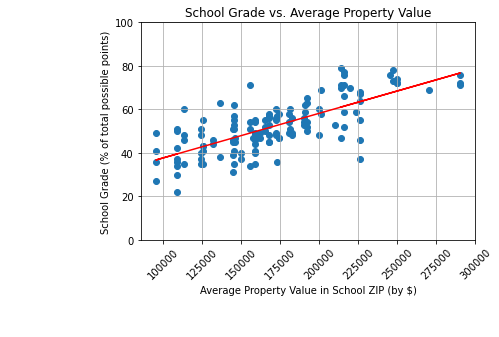

In [120]:
#Create scatter plot w/ regression line for school grade vs. prop value

# Set x and y values for scatter plot
x_values = grade_w_value_19['Avg Prop Value']
y_values = grade_w_value_19['Percent of Total Possible Points']

# Perform a linear regression on school grade vs. average property value
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# Get regression values
regress_values = x_values * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

# Create scatter plot and
# set plot specs
plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Average Property Value in School ZIP (by $)')
plt.ylabel("School Grade (% of total possible points)")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.annotate(line_eq,(5,-40),fontsize=15,color="red")
plt.grid(which='major', axis='both')
plt.title("School Grade vs. Average Property Value")

# Print r value
print(f"The r- is: {rvalue**2}")

# Display plot
plt.show()

In [126]:
stats.pearsonr(x_values, y_values)

(0.7352022323680258, 7.106481765786149e-24)

The r- is: 0.6696005372364051


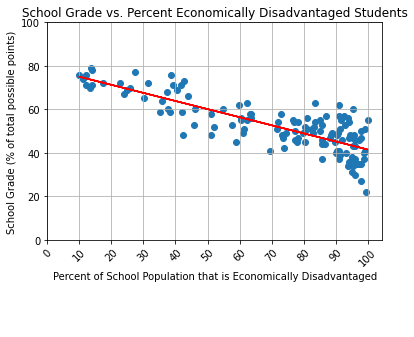

In [125]:
# Create scatter plot w/ regression line for school grade vs percent economically disadvantaged

# Set x and y values for scatter plot
x_values1 = grade_w_value_19['Percent of Economically Disadvantaged Students']
y_values1 = grade_w_value_19['Percent of Total Possible Points']

# Perform a linear regression on school grade vs. average property value
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values1, y_values1)

# Get regression values
regress_values = x_values1 * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

# Create scatter plot and
# set plot specs
plt.scatter(x_values1, y_values1)
plt.plot(x_values1,regress_values,"r-")
plt.xlabel('Percent of School Population that is Economically Disadvantaged')
plt.ylabel("School Grade (% of total possible points)")
plt.ylim(0, 100)
plt.xticks(np.arange(0, 105, step=10), rotation=45)
plt.annotate(line_eq,(5,-40),fontsize=15,color="red")
plt.grid(which='major', axis='both')
plt.title("School Grade vs. Percent Economically Disadvantaged Students")

# Print r value
print(f"The r- is: {rvalue**2}")

# Display plot
plt.show()

In [127]:
stats.pearsonr(x_values1, y_values1)

(-0.818291230086456, 2.6610142218912062e-33)

The r- is: 0.6220365565046729


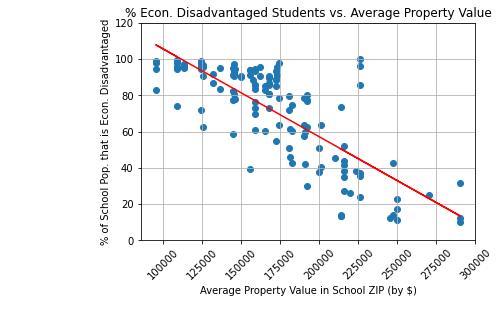

In [134]:
# Create scatter plot w/ regression line for percent economically disadvantaged vs prop value

# Set x and y values for scatter plot
x_values2 = grade_w_value_19['Avg Prop Value']
y_values2 = grade_w_value_19['Percent of Economically Disadvantaged Students']

# Perform a linear regression on school grade vs. average property value
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values2, y_values2)

# Get regression values
regress_values = x_values2 * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

# Create scatter plot and
# set plot specs
plt.scatter(x_values2, y_values2)
plt.plot(x_values2,regress_values,"r-")
plt.xlabel('Average Property Value in School ZIP (by $)')
plt.ylabel("% of School Pop. that is Econ. Disadvantaged")
plt.ylim(0, 120)
plt.xticks(rotation=45)
plt.annotate(line_eq,(5,-40),fontsize=15,color="red")
plt.grid(which='major', axis='both')
plt.title("% Econ. Disadvantaged Students vs. Average Property Value")

# Print r value
print(f"The r- is: {rvalue**2}")

# Display plot
plt.show()